In [ ]:
%load_ext autoreload
%autoreload 2
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
import numpy as np
from surfbreak.detection import detect_surfzone, trim_image
video_filepath='../../data/shirahama_1590387334_SURF-93cm.ts'

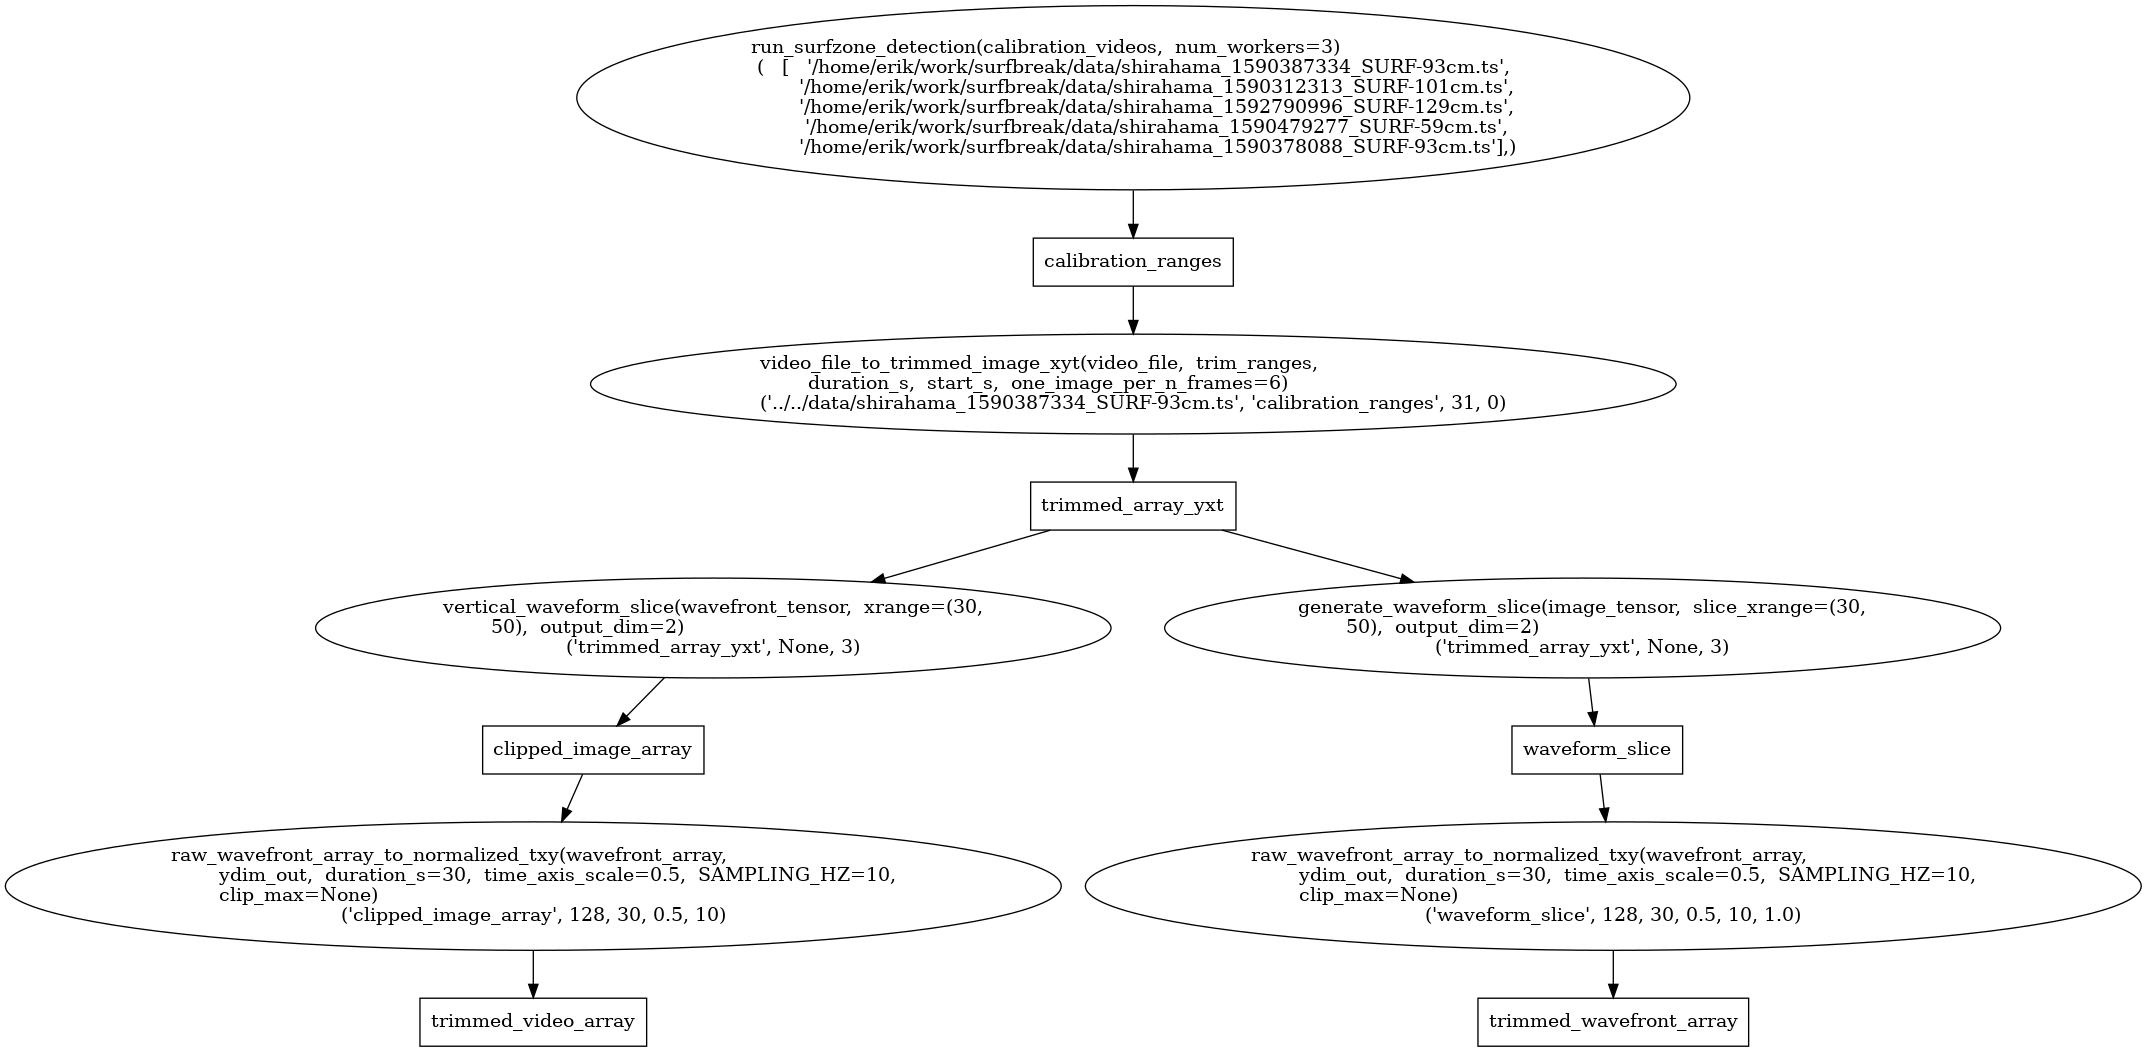

In [ ]:
from surfbreak.pipelines import video_to_waveform_array_txy
from surfbreak.graphutils import visualize
dask_graph = video_to_waveform_array_txy(video_filepath, ydim_out=128)
visualize(dask_graph, rankdir='UD')

In [ ]:
import graphchain
import matplotlib.pyplot as plt
vid_array = graphchain.get(dask_graph, 'trimmed_video_array')
wavefront_array = graphchain.get(dask_graph, 'trimmed_wavefront_array')
print(vid_array.shape)
for t in range(3):
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    ax[0].imshow(wavefront_array[t*5].T)
    ax[1].imshow(vid_array[t*5].T)
    plt.show()

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 


## Now load pre-trained CNN for wavefront detection
Details can be found in [11_simple_wave_detector.ipynb](../11_simple_wave_detector.ipynb)

In [ ]:
from surfbreak.waveform_models import LitWaveCNN
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset, InferredWavefrontDataset

video_filepath='../../data/shirahama_1590387334_SURF-93cm.ts'
cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'

wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,3),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)
infwfs_dataset = InferredWavefrontDataset(wfs_dataset, cnn_checkpoint)

import matplotlib.pyplot as plt
wfs_in, wfs_gt = wfs_dataset[0]
inf_in, inf_gt = infwfs_dataset[0]

for t_idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(20,3))
    axes[0].imshow(wfs_gt["video_txy"][t_idx].T)
    axes[1].imshow(wfs_gt["wavefronts_txy"][t_idx].T)
    axes[2].imshow(inf_gt["wavefronts_txy"][t_idx].T)

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedWavefrontDataset, InferredWavefrontDataset

training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'

max_epochs=4
wf_net_kwargs = dict(
    hidden_features=256,
    hidden_layers=3,
    first_omega_0=2.5,
    hidden_omega_0=11,
    squared_slowness=1.0, #0.2
    learning_rate=1e-4,
    wavefunc_loss_scale=1e-12, #1e-12, #5.5e-9,
    wavespeed_loss_scale=1e-13, #1e-15, #4e-4, 
    wavespeed_first_omega_0=0.5, #0.75, #0.5  <-- good, but too strongly regularized?, #1.0, #3.5, 
    wavespeed_hidden_omega_0=2.0 #<-- good, but too strongly regularized?, #15, 
)

def train_wfmodel(training_video, cnn_checkpoint, max_epochs, wf_net_kwargs, start_minute=0):
    raw_wfs_dataset = WavefrontSupervisionDataset(training_video, timerange=(start_minute*60,(start_minute+2)*60), 
                                                  time_chunk_duration_s=1, time_chunk_stride_s=1)
    txy_cache = CachedDataset(InferredWavefrontDataset, raw_wfs_dataset, cnn_checkpoint)
    wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=0.5)
    wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    viz_wftxy_dataset = WavefrontSupervisionDataset(training_video, timerange=(start_minute*60,(start_minute+1)*60), 
                                                  time_chunk_duration_s=30, time_chunk_stride_s=30)
    viz_inftxy_dataset = InferredWavefrontDataset(viz_wftxy_dataset, cnn_checkpoint)

    wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                                 viz_dataset=viz_inftxy_dataset, batch_size=64,
                                 **wf_net_kwargs)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="wfnet")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=30,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None)
                         #track_grad_norm=2)

    pl.seed_everything(42)
    trainer.fit(wavefunc_model)
    return wavefunc_model

In [ ]:
import matplotlib.pyplot as plt 

slowness_arrays = []
for sm in range(0,6,2):
    print("Start minute: ",sm)
    wf_model = train_wfmodel(training_video, cnn_checkpoint, max_epochs, wf_net_kwargs, start_minute=sm)
    slowness_arrays.append(wf_model.slowness_array)
print("Done")

In [ ]:
for array in slowness_arrays:
    plt.imshow(array.T)
    plt.colorbar(orientation='horizontal')
    plt.show()

## Optimize via optuna

In [ ]:
import os
import torch
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
from surfbreak.studies import run_waveform_hyperparam_search, MetricsCallback

from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedWavefrontDataset, InferredWavefrontDataset

LOGDIR = 'logs'
MODELDIR = os.path.join(LOGDIR, 'opt_models')

def objective(trial):
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint( # Filenames for each trial must be made unique
        os.path.join(MODELDIR, "trial_{}".format(trial.number), "{epoch}"), monitor="val_loss")
    tb_logger = pl.loggers.TensorBoardLogger(LOGDIR+'/', name="optuna")
    metrics_callback = MetricsCallback()     # Simple callback that saves metrics from each validation step.
    pl.seed_everything(42)

    
    training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
    cnn_checkpoint ='../../bestlogs/simplecnn/checkpoints/epoch=19.ckpt'
    max_epochs=5
    wf_net_kwargs = dict(
        hidden_features=256,
        hidden_layers=3,
        first_omega_0=trial.suggest_uniform('first_omega_0', 0.1, 5.0), #1.5, 
        hidden_omega_0=trial.suggest_uniform('hidden_omega_0', 1, 30), #11.7,
        squared_slowness=1.0, #0.23,
        learning_rate=5e-5, 
        wavefunc_loss_scale=trial.suggest_loguniform('wavefunc_loss_scale', 5e-12, 1e-9), #5e-9,
        wavespeed_loss_scale=trial.suggest_loguniform('wavespeed_loss_scale', 1e-13, 1e-9), #1e-3
        wavespeed_first_omega_0=trial.suggest_uniform('wavespeed_first_omega_0',1e-3,1.0), #3.5, 
        wavespeed_hidden_omega_0=trial.suggest_uniform('wavespeed_hidden_omega_0',1e-3,5), #15, 
    )

    raw_wfs_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,3*60), 
                                                  time_chunk_duration_s=1, time_chunk_stride_s=1)
    txy_cache = CachedDataset(InferredWavefrontDataset, raw_wfs_dataset, cnn_checkpoint)
    wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    viz_wftxy_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,60), 
                                                  time_chunk_duration_s=30, time_chunk_stride_s=30)
    viz_inftxy_dataset = InferredWavefrontDataset(viz_wftxy_dataset, cnn_checkpoint)

    wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                                 viz_dataset=viz_inftxy_dataset, batch_size=64,
                                 **wf_net_kwargs)

    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=50,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,
                         callbacks=[metrics_callback],
                         early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                        )
    trainer.fit(wavefunc_model)
    
    return metrics_callback.metrics[-1]["val_loss"].item()


study = run_waveform_hyperparam_search(objective, n_trials=100, timeout=8*60*60, model_dir=MODELDIR, 
                                       prune=True, n_startup_trials=3, n_warmup_steps=3)
